In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

Get the worst-case (smallest) spot size

(194, 194)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/F1_to_K3_config_3_field_1_results.npz Parameter('x_mean', value=0.021351631120918778) Parameter('y_mean', value=0.005047161939973764) 0.076428463010836 0.1346432881007718 Parameter('theta', value=0.0375996975089838)
(194, 194)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/F1_to_K3_config_3_field_8_results.npz Parameter('x_mean', value=-0.13633014574705563) Parameter('y_mean', value=-0.013217015627153331) 0.08156954402916915 0.11360507835349108 Parameter('theta', value=-0.4443504581902329)
(194, 194)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/K2_to_K1_config_3_field_1_results.npz Parameter('x_mean', value=0.030527924776154715) Parameter('y_mean', value=-0.002458543976127725) 0.04942303948461133 0.08772866111352139 Parameter('theta', value=0.023099658341173553)
(194, 194)
/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/K2_to_K1_config_3_field_8_results

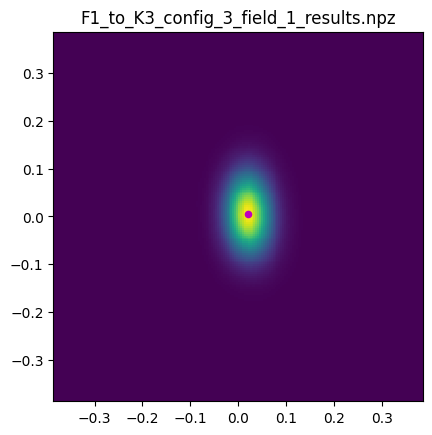

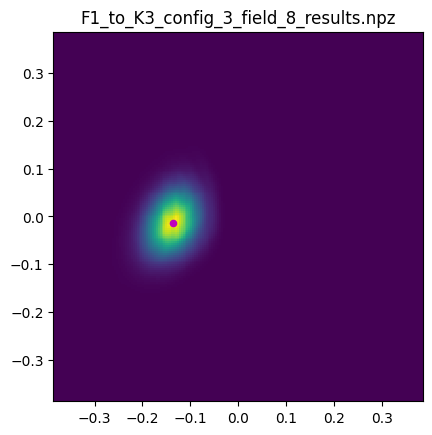

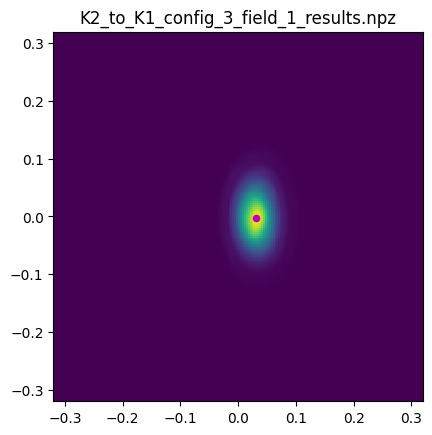

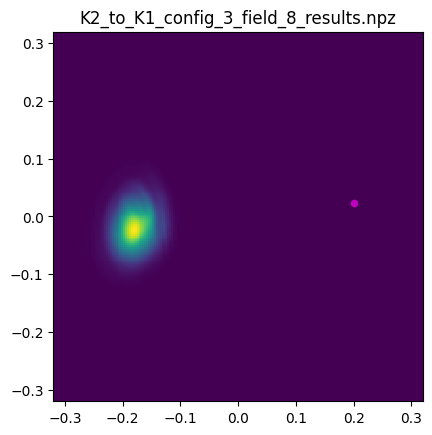

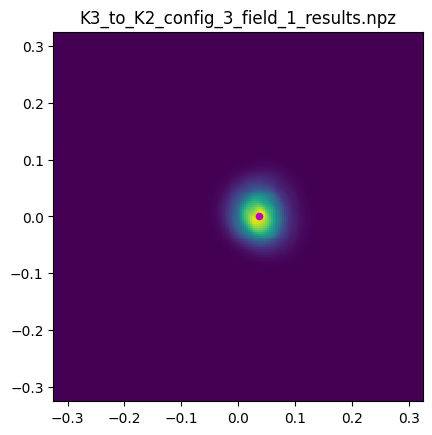

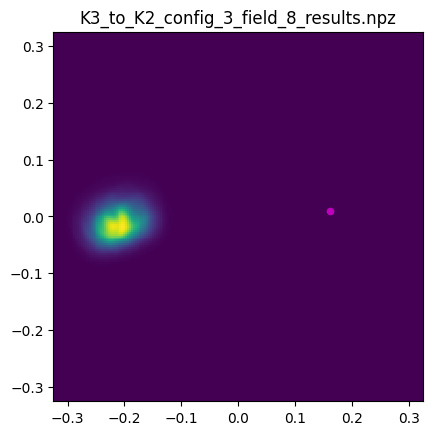

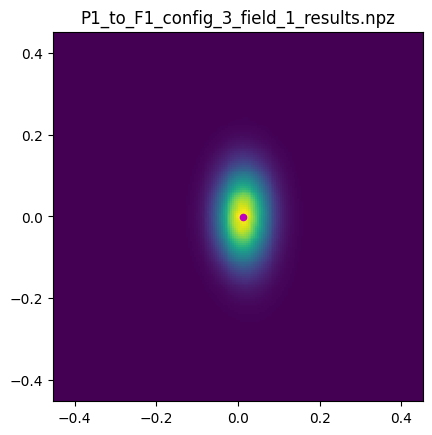

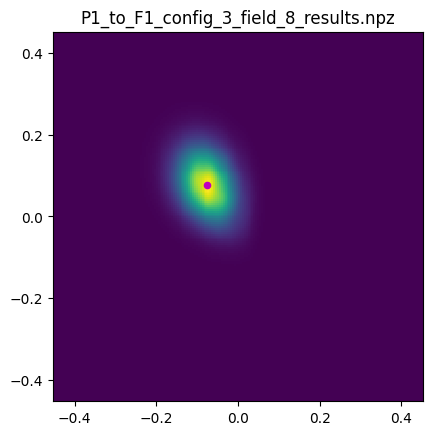

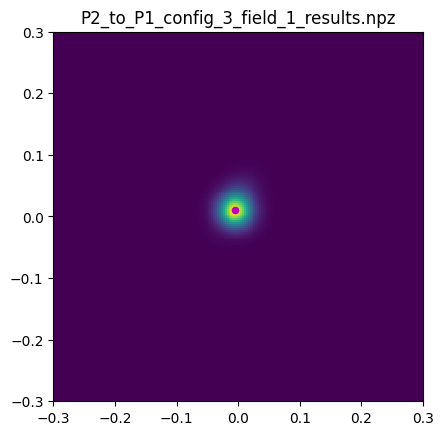

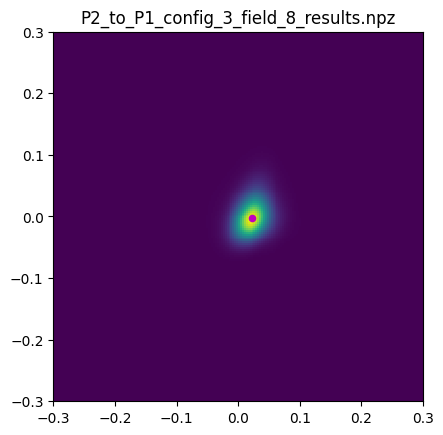

In [3]:
files = glob.glob('/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/*results.npz')
smallest_x = np.inf
smallest_y = np.inf
smallest_file_x = ''
smallest_file_y = ''
for file in sorted(files):
    if ("FLANGE" in file) or ("arb" in file):
        continue
    data = np.load(file)
    xx = data['xx_img']
    yy = data['yy_img']
    img = np.abs(data['fresnel_img']) ** 2.
    print(xx.shape)

    fig, ax = plt.subplots()
    ax.pcolormesh(xx, yy, img)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_aspect('equal')
    ax.set_title(os.path.basename(file))

    # fit a 2D Gaussian to data and extract fit params
    p_init = Gaussian2D(
        amplitude=img.max(),
        x_mean=0.,
        y_mean=0.,
        x_stddev=0.1,
        y_stddev=0.1
    )
    fit_p = LevMarLSQFitter()
    p = fit_p(p_init, xx, yy, img)
    print(file, p.x_mean, p.y_mean, p.x_fwhm, p.y_fwhm, p.theta)
    ax.scatter(p.x_mean.value, p.y_mean.value, s=20, color='m')
    if p.x_fwhm < smallest_x and p.x_fwhm > 1e-9:
        smallest_x = p.x_fwhm
        smallest_file_x = file
    if p.x_fwhm < smallest_y and p.y_fwhm > 1e-9:
        smallest_y = p.y_fwhm
        smallest_file_y = file
print(os.path.basename(smallest_file_x), smallest_x)
print(os.path.basename(smallest_file_y), smallest_y)

Get the field with the largest gradient anywhere inside the beam

P2_to_P1_config_3_field_1_results.npz 9.720570836866122e-05


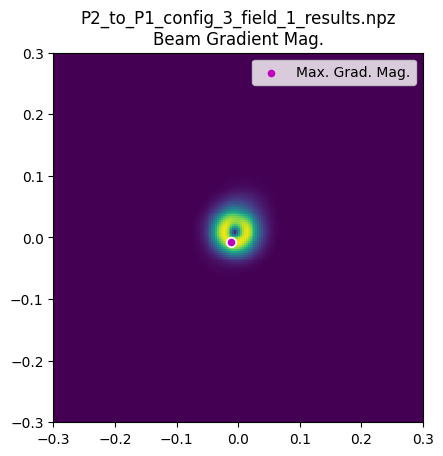

In [44]:
files = glob.glob('/home/evanmayer/TIME_data/mirror_mapping/zemax/pop_system/results/*results.npz')
largest_grad = -np.inf
largest_grad_ix = 0
largest_grad_iy = 0
largest_grad_file = ''
for file in sorted(files):
    if ("FLANGE" in file) or ("arb" in file):
        continue
    data = np.load(file)
    xx = data['xx_img']
    yy = data['yy_img']
    intensity = np.abs(data['fresnel_img']) ** 2.
    grad_mag = np.linalg.norm(np.gradient(intensity), axis=0)
    # print(xx.shape)

    iy, ix = np.unravel_index(grad_mag.argmax(), grad_mag.shape)
    this_grad_max = grad_mag[iy, ix]

    if this_grad_max > largest_grad:
        largest_grad_arr = grad_mag
        largest_grad_int = intensity
        largest_grad = this_grad_max
        largest_grad_ix = ix
        largest_grad_iy = iy
        largest_grad_xx = xx
        largest_grad_yy = yy
        largest_grad_file = file

fig, ax = plt.subplots()
ax.pcolormesh(largest_grad_xx, largest_grad_yy, largest_grad_arr)#, levels=20)
ax.set_xlim(largest_grad_xx.min(), largest_grad_xx.max())
ax.set_ylim(largest_grad_yy.min(), largest_grad_yy.max())
ax.set_aspect('equal')
ax.set_title(os.path.basename(largest_grad_file) + '\nBeam Gradient Mag.')
ax.scatter(
    largest_grad_xx[largest_grad_iy, largest_grad_ix],
    largest_grad_yy[largest_grad_iy, largest_grad_ix],
    s=50,
    color='w'
)
ax.scatter(
    largest_grad_xx[largest_grad_iy, largest_grad_ix],
    largest_grad_yy[largest_grad_iy, largest_grad_ix],
    s=20,
    color='m',
    label='Max. Grad. Mag.'
)
ax.legend()
print(os.path.basename(largest_grad_file), largest_grad)

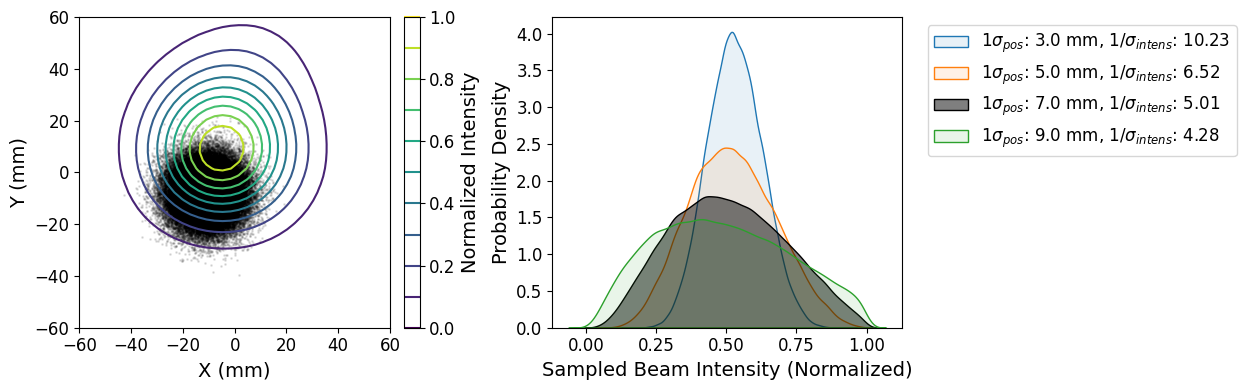

In [101]:
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import iqr
import seaborn as sns

scale = 1e3 # m to mm

center = [
    largest_grad_xx[largest_grad_iy, largest_grad_ix] * scale,
    largest_grad_yy[largest_grad_iy, largest_grad_ix] * scale,
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
im = axes[0].contour(largest_grad_xx*scale, largest_grad_yy*scale, largest_grad_int/largest_grad_int.max(), levels=11)
cb = plt.colorbar(
    im,
    fraction=0.046,
    pad=0.04,
    ax=axes[0],
)
cb.set_label('Normalized Intensity', fontsize=14)
cb.ax.tick_params(labelsize=12)
zoom = 5 / scale
axes[0].set_xlim(largest_grad_xx.min() / zoom, largest_grad_xx.max() / zoom)
axes[0].set_ylim(largest_grad_yy.min() / zoom, largest_grad_yy.max() / zoom)
axes[0].set_aspect('equal')
axes[0].tick_params(labelsize=12)
axes[0].set_xlabel('X (mm)', fontsize=14)
axes[0].set_ylabel('Y (mm)', fontsize=14)

axes[1].tick_params(labelsize=12)
axes[1].set_xlabel('Sampled Beam Intensity (Normalized)', fontsize=14)
axes[1].set_ylabel('Probability Density', fontsize=14)

# Estimate the SNR for an array of Gaussian jitters about the point of highest gradient.
N = int(1e5)
rng = np.random.default_rng(seed=77777)
jitter_sigmas = np.array([3e-3, 5e-3, 7e-3, 9e-3]) * scale #np.logspace(-2.2, -2, num=10) * scale
peak = largest_grad_int.max()
for sigma in jitter_sigmas:
    cov = np.eye(2, dtype=float) * (sigma ** 2)
    x, y = rng.multivariate_normal(center, cov, size=N).T
    # sample the beam at each point to get a distribution of intensities
    x_arr = largest_grad_xx[0,:] * scale
    y_arr = largest_grad_yy[:,0] * scale
    interp = RegularGridInterpolator((x_arr, y_arr), largest_grad_int)
    pts = np.vstack([x,y]).T
    out = interp(pts) / peak
    out_iqr = iqr(out)

    # print(out.std(), out_iqr)

    if abs(sigma - 7e-3 * scale) < np.finfo(float).eps:
        alpha=0.5
        color='k'
        axes[0].scatter(x,y, s=1, alpha=.1, color=color, zorder=0)
    else:
        alpha=0.1
        color=None
    sns.kdeplot(
        out,
        fill=True,
        alpha=alpha, 
        ax=axes[1],
        color=color,
        label=f'1$\sigma_{{pos}}$: {sigma:.1f} mm, 1/$\sigma_{{intens}}$: {1/out.std():.2f}'
    )#, Peak/iqr: {1/out_iqr}')

axes[1].legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, loc='upper left')
fig.tight_layout()
fig.savefig('/home/evanmayer/Documents/writing/papers/mirror_mapper/repeatability_pdf.png', bbox_inches='tight', dpi=150)

In [6]:
vals = rng.standard_normal(size=N)
vals.std()

0.9996195220365452

In [7]:
iqr(vals, rng=(50 - 68.2/2, 50 + 68.2/2))

1.991656978007758